# Autoencoder for dim064 dataset

In [1]:
import pandas as pd
import numpy as np
from keras.models import Model,load_model
from keras.callbacks import ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
from keras import regularizers
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D
from keras.models import Model
from keras import backend as K

Using TensorFlow backend.


In [96]:
#read data
x_train = pd.read_csv('dataset/dim064_train.csv')
x_test = pd.read_csv('dataset/dim064_test.csv')
#y_train = pd.read_csv('dataset/dim064_train_label.csv')
#y_train = np.asarray(y_train)
#y_test = pd.read_csv('dataset/dim064_test_label.csv')
#y_test = np.asarray(y_test)

In [97]:
# ## Normalization
# #x_train.max().max()
# x_train = x_train.astype('float32') / 157.
# x_test = x_test.astype('float32') / 157.

# Basic Autoencoder

In [138]:
########### Basic Autoencoder ##########
input_dim = x_train.shape[1]
input_layer = Input(shape=(input_dim, ))

encoding_dim = 12
#learning_rate = 1e-7

encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# implenment an autoencoder, creat encoder and decoder

autoencoder = Model(input_layer, decoded)

encoder = Model(input_layer, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
                                             
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        (None, 64)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 12)                780       
_________________________________________________________________
dense_41 (Dense)             (None, 64)                832       
Total params: 1,612
Trainable params: 1,612
Non-trainable params: 0
_________________________________________________________________


In [139]:
ae_train = autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=128,
                shuffle=False,
                validation_data=(x_test, x_test),
                verbose = 0
                ).history

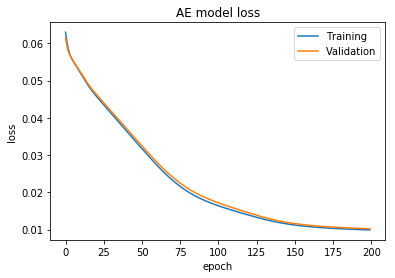

In [140]:
# AE loss
plt.plot(ae_train['loss'])
plt.plot(ae_train['val_loss'])
plt.title('AE model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [137]:
# create encoded data
encoded_data = encoder.predict(x_test)
#decoded_data = decoder.predict(encoded_data)

# transform to SOM input type
encoded_som = pd.DataFrame(encoded_data)
#decoded_som = pd.DataFrame(decoded_data)

# get rid of columns with all zeros
nonzero = list(map(lambda i: any(encoded_data[:,i] != 0), range(encoded_data.shape[1])))
encoded_som_nonzero = pd.DataFrame(encoded_data[:,nonzero])
encoded_som_nonzero.to_csv(path_or_buf='output/dim064_AE_encoded.csv',index= False)

# Sparse Autoencoder

In [15]:
########### Sparse Autoencoder ##########
input_dim = x_train.shape[1]
input_layer = Input(shape=(input_dim, ))

encoding_dim = 12
#learning_rate = 1e-7

encoded = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-7))(input_layer)

decoded = Dense(input_dim, activation='sigmoid')(encoded)

# implenment an autoencoder, creat encoder and decoder

autoencoder = Model(input_layer, decoded)

encoder = Model(input_layer, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
                                             
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                780       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                832       
Total params: 1,612
Trainable params: 1,612
Non-trainable params: 0
_________________________________________________________________


In [17]:


ae_train = autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=128,
                shuffle=False,
                validation_data=(x_test, x_test)
                ).history

Train on 614 samples, validate on 410 samples
Epoch 1/200
614/614 [==============================] - 1s 1ms/step - loss: 0.0656 - val_loss: 0.0635
Epoch 2/200
614/614 [==============================] - 0s 38us/step - loss: 0.0625 - val_loss: 0.0610
Epoch 3/200
614/614 [==============================] - 0s 38us/step - loss: 0.0603 - val_loss: 0.0592
Epoch 4/200
614/614 [==============================] - 0s 37us/step - loss: 0.0587 - val_loss: 0.0580
Epoch 5/200
614/614 [==============================] - 0s 37us/step - loss: 0.0576 - val_loss: 0.0571
Epoch 6/200
614/614 [==============================] - 0s 34us/step - loss: 0.0568 - val_loss: 0.0566
Epoch 7/200
614/614 [==============================] - 0s 38us/step - loss: 0.0563 - val_loss: 0.0561
Epoch 8/200
614/614 [==============================] - 0s 37us/step - loss: 0.0558 - val_loss: 0.0556
Epoch 9/200
614/614 [==============================] - 0s 35us/step - loss: 0.0553 - val_loss: 0.0552
Epoch 10/200
614/614 [===============

614/614 [==============================] - 0s 40us/step - loss: 0.0347 - val_loss: 0.0353
Epoch 81/200
614/614 [==============================] - 0s 38us/step - loss: 0.0345 - val_loss: 0.0351
Epoch 82/200
614/614 [==============================] - 0s 38us/step - loss: 0.0343 - val_loss: 0.0349
Epoch 83/200
614/614 [==============================] - 0s 33us/step - loss: 0.0341 - val_loss: 0.0347
Epoch 84/200
614/614 [==============================] - 0s 35us/step - loss: 0.0340 - val_loss: 0.0346
Epoch 85/200
614/614 [==============================] - 0s 32us/step - loss: 0.0338 - val_loss: 0.0344
Epoch 86/200
614/614 [==============================] - 0s 34us/step - loss: 0.0336 - val_loss: 0.0342
Epoch 87/200
614/614 [==============================] - 0s 31us/step - loss: 0.0335 - val_loss: 0.0341
Epoch 88/200
614/614 [==============================] - 0s 34us/step - loss: 0.0333 - val_loss: 0.0339
Epoch 89/200
614/614 [==============================] - 0s 34us/step - loss: 0.0332 - 

614/614 [==============================] - 0s 35us/step - loss: 0.0283 - val_loss: 0.0287
Epoch 160/200
614/614 [==============================] - 0s 35us/step - loss: 0.0282 - val_loss: 0.0286
Epoch 161/200
614/614 [==============================] - 0s 35us/step - loss: 0.0282 - val_loss: 0.0286
Epoch 162/200
614/614 [==============================] - 0s 31us/step - loss: 0.0282 - val_loss: 0.0285
Epoch 163/200
614/614 [==============================] - 0s 32us/step - loss: 0.0281 - val_loss: 0.0285
Epoch 164/200
614/614 [==============================] - 0s 32us/step - loss: 0.0281 - val_loss: 0.0285
Epoch 165/200
614/614 [==============================] - 0s 30us/step - loss: 0.0281 - val_loss: 0.0284
Epoch 166/200
614/614 [==============================] - 0s 35us/step - loss: 0.0280 - val_loss: 0.0284
Epoch 167/200
614/614 [==============================] - 0s 32us/step - loss: 0.0280 - val_loss: 0.0283
Epoch 168/200
614/614 [==============================] - 0s 32us/step - loss: 

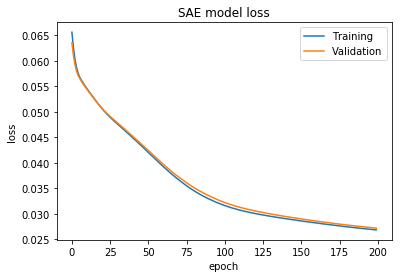

In [18]:
# SAE loss
plt.plot(ae_train['loss'])
plt.plot(ae_train['val_loss'])
plt.title('SAE model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [19]:
loss = pd.DataFrame(ae_train['loss'])
loss.describe()

,0
count,200.000000
mean,0.035916
std,0.009271
min,0.026856
25%,0.028645
50%,0.031669
75%,0.042094
max,0.065571


In [20]:
val_loss = pd.DataFrame(ae_train['val_loss'])
val_loss.describe()

,0
count,200.000000
mean,0.036263
std,0.009051
min,0.027208
25%,0.029038
50%,0.032269
75%,0.042447
max,0.063496


In [21]:
# create encoded data
encoded_data = encoder.predict(x_test)
#decoded_data = decoder.predict(encoded_data)

# transform to SOM input type
encoded_som = pd.DataFrame(encoded_data)
#decoded_som = pd.DataFrame(decoded_data)

In [22]:
encoded_data.mean()

0.5563663

In [23]:
encoded_som.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.664871,1.604236,-0.0,-0.0,-0.0,-0.0,1.820850,0.125911,1.076730,-0.0,-0.0,-0.0
1,1.307412,3.301665,-0.0,-0.0,-0.0,-0.0,1.332330,2.137808,3.064919,-0.0,-0.0,-0.0
2,0.424076,2.190599,-0.0,-0.0,-0.0,-0.0,1.661273,0.449278,1.538921,-0.0,-0.0,-0.0
3,0.881969,-0.000000,-0.0,-0.0,-0.0,-0.0,2.855966,1.652026,0.310751,-0.0,-0.0,-0.0
4,0.049503,1.354315,-0.0,-0.0,-0.0,-0.0,-0.000000,0.223567,-0.000000,-0.0,-0.0,-0.0


In [24]:
nonzero = list(map(lambda i: any(encoded_data[:,i] != 0), range(encoded_data.shape[1])))
encoded_som_nonzero = pd.DataFrame(encoded_data[:,nonzero])
encoded_som_nonzero.tail()

,0,1,2,3,4
405,1.668378,1.617260,1.806663,0.155295,1.081879
406,-0.000000,1.761137,3.487840,2.212331,1.849533
407,2.477036,2.054956,0.555728,-0.000000,0.851163
408,0.015561,1.352780,-0.000000,0.202852,-0.000000
409,-0.000000,2.656603,1.024365,-0.000000,1.166874


In [25]:
encoded_som_nonzero.to_csv(path_or_buf='output/dim064_SAE_encoded.csv',index= False)

# Contractive Autoencoder

In [26]:
########### Contractive Autoencoder ##########
input_dim = x_train.shape[1]
input_layer = Input(shape=(input_dim, ))

encoding_dim = 12
#learning_rate = 1e-7

encoded = Dense(encoding_dim, activation='relu', name = 'encoded')(input_layer)

decoded = Dense(input_dim, activation='sigmoid')(encoded)

# implenment an autoencoder, creat encoder and decoder

autoencoder = Model(input_layer, decoded)

encoder = Model(input_layer, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

lam = 10e-6

def contractive_loss(y_pred, y_true):
    
        mse = K.mean(K.square(y_true - y_pred), axis=1)
        W = K.variable(value=autoencoder.get_layer('encoded').get_weights()[0])
        W = K.transpose(W)
        h = autoencoder.get_layer('encoded').output
        dh = h * (1 - h)
        contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1)

        return mse + contractive
    
autoencoder.compile(optimizer='adam', loss= contractive_loss)
ae_train = autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test)
                ).history

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 614 samples, validate on 410 samples
Epoch 1/200
614/614 [==============================] - 1s 2ms/step - loss: 0.0639 - val_loss: 0.0619
Epoch 2/200
614/614 [==============================] - 0s 42us/step - loss: 0.0606 - val_loss: 0.0594
Epoch 3/200
614/614 [==============================] - 0s 37us/step - loss: 0.0585 - val_loss: 0.0578
Epoch 4/200
614/614 [==============================] - 0s 35us/step - loss: 0.0571 - val_loss: 0.0568
Epoch 5/200
614/614 [==============================] - 0s 35us/step - loss: 0.0562 - val_loss: 0.0560
Epoch 6/200
614/614 [==============================] - 0s 34us/step - loss: 0.0555 - val_loss: 0.0553
Epoch 7/200
614/614 [==============================] - 0s 37us/step - loss: 0.0549 - val_loss: 0.0548
Epoch 8/200
614/614 [==============================] - 0s 32us/step - loss: 0.0543 - val_loss: 0.0542
Epoch 9/200
614/614 [========================

Epoch 77/200
614/614 [==============================] - 0s 41us/step - loss: 0.0252 - val_loss: 0.0251
Epoch 78/200
614/614 [==============================] - 0s 41us/step - loss: 0.0250 - val_loss: 0.0249
Epoch 79/200
614/614 [==============================] - 0s 41us/step - loss: 0.0247 - val_loss: 0.0246
Epoch 80/200
614/614 [==============================] - 0s 38us/step - loss: 0.0245 - val_loss: 0.0244
Epoch 81/200
614/614 [==============================] - 0s 39us/step - loss: 0.0243 - val_loss: 0.0242
Epoch 82/200
614/614 [==============================] - 0s 34us/step - loss: 0.0241 - val_loss: 0.0240
Epoch 83/200
614/614 [==============================] - 0s 37us/step - loss: 0.0239 - val_loss: 0.0238
Epoch 84/200
614/614 [==============================] - 0s 37us/step - loss: 0.0237 - val_loss: 0.0236
Epoch 85/200
614/614 [==============================] - 0s 39us/step - loss: 0.0235 - val_loss: 0.0234
Epoch 86/200
614/614 [==============================] - 0s 36us/step - lo

Epoch 156/200
614/614 [==============================] - 0s 39us/step - loss: 0.0173 - val_loss: 0.0172
Epoch 157/200
614/614 [==============================] - 0s 40us/step - loss: 0.0173 - val_loss: 0.0171
Epoch 158/200
614/614 [==============================] - 0s 36us/step - loss: 0.0172 - val_loss: 0.0171
Epoch 159/200
614/614 [==============================] - 0s 38us/step - loss: 0.0172 - val_loss: 0.0171
Epoch 160/200
614/614 [==============================] - 0s 38us/step - loss: 0.0172 - val_loss: 0.0170
Epoch 161/200
614/614 [==============================] - 0s 38us/step - loss: 0.0171 - val_loss: 0.0170
Epoch 162/200
614/614 [==============================] - 0s 40us/step - loss: 0.0171 - val_loss: 0.0170
Epoch 163/200
614/614 [==============================] - 0s 37us/step - loss: 0.0171 - val_loss: 0.0169
Epoch 164/200
614/614 [==============================] - 0s 38us/step - loss: 0.0170 - val_loss: 0.0169
Epoch 165/200
614/614 [==============================] - 0s 40us

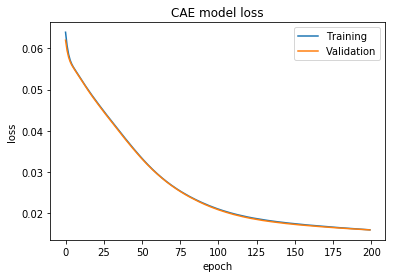

In [27]:
# CAE loss
plt.plot(ae_train['loss'])
plt.plot(ae_train['val_loss'])
plt.title('CAE model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [28]:
loss = pd.DataFrame(ae_train['loss'])
loss.describe()

,0
count,200.000000
mean,0.026834
std,0.012162
min,0.016024
25%,0.017521
50%,0.021098
75%,0.033431
max,0.063864


In [29]:
val_loss = pd.DataFrame(ae_train['val_loss'])
val_loss.describe()

,0
count,200.000000
mean,0.026681
std,0.012098
min,0.016006
25%,0.017361
50%,0.020940
75%,0.033300
max,0.061931


In [30]:
# create encoded data
encoded_data = encoder.predict(x_test)
#decoded_data = decoder.predict(encoded_data)

# transform to SOM input type
encoded_som = pd.DataFrame(encoded_data)
#decoded_som = pd.DataFrame(decoded_data)

In [31]:
encoded_data.mean()

0.758724

In [32]:
encoded_som.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.132602,0.194167,1.657366,2.710675,-0.0,-0.0,-0.0,-0.000000,2.290873,1.387486,-0.0,1.273360
1,2.205261,-0.000000,1.358912,2.794274,-0.0,-0.0,-0.0,0.713635,-0.000000,0.988429,-0.0,0.828771
2,0.822687,1.849295,1.304578,1.202002,-0.0,-0.0,-0.0,-0.000000,-0.000000,0.006992,-0.0,2.366884
3,-0.000000,-0.000000,1.332502,-0.000000,-0.0,-0.0,-0.0,-0.000000,1.091135,0.888521,-0.0,2.753647
4,0.893103,1.129324,-0.000000,1.983290,-0.0,-0.0,-0.0,2.293613,2.785163,1.220750,-0.0,2.000231


In [33]:
nonzero = list(map(lambda i: any(encoded_data[:,i] != 0), range(encoded_data.shape[1])))

encoded_som_nonzero = pd.DataFrame(encoded_data[:,nonzero])

encoded_som_nonzero.tail()

,0,1,2,3,4,5,6,7
405,0.141181,0.178557,1.647035,2.695401,-0.000000,2.267053,1.390108,1.261057
406,0.515937,0.503931,0.797596,1.616801,-0.000000,-0.000000,2.668694,2.766420
407,0.112266,1.331057,1.710154,1.976139,-0.000000,1.681474,0.283597,-0.000000
408,0.900244,1.141552,-0.000000,2.008343,2.304365,2.814506,1.248465,2.030923
409,1.569984,3.347661,-0.000000,1.894827,-0.000000,0.456848,1.632554,1.713374


In [34]:
encoded_som_nonzero.to_csv(path_or_buf='output/dim064_CAE_encoded.csv',index= False)

# Denoising Autoencoder

In [35]:
############ Denoiding Autoencoder ###########

# add noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

input_dim = x_train.shape[1]
input_layer = Input(shape=(input_dim, ))

encoding_dim = 12
#learning_rate = 1e-7

encoded = Dense(encoding_dim, activation='relu')(input_layer)

decoded = Dense(input_dim, activation='sigmoid')(encoded)

# implenment an autoencoder, creat encoder and decoder

autoencoder = Model(input_layer, decoded)

encoder = Model(input_layer, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
                                             
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

ae_train = autoencoder.fit(x_train_noisy, x_train,
                epochs=200,
                batch_size=128,
                shuffle=False,
                validation_data=(x_test_noisy, x_test)
                ).history

Train on 614 samples, validate on 410 samples
Epoch 1/200
614/614 [==============================] - 1s 1ms/step - loss: 0.0626 - val_loss: 0.0613
Epoch 2/200
614/614 [==============================] - 0s 35us/step - loss: 0.0604 - val_loss: 0.0597
Epoch 3/200
614/614 [==============================] - 0s 36us/step - loss: 0.0590 - val_loss: 0.0587
Epoch 4/200
614/614 [==============================] - 0s 35us/step - loss: 0.0582 - val_loss: 0.0581
Epoch 5/200
614/614 [==============================] - 0s 34us/step - loss: 0.0576 - val_loss: 0.0576
Epoch 6/200
614/614 [==============================] - 0s 35us/step - loss: 0.0572 - val_loss: 0.0573
Epoch 7/200
614/614 [==============================] - 0s 36us/step - loss: 0.0569 - val_loss: 0.0570
Epoch 8/200
614/614 [==============================] - 0s 34us/step - loss: 0.0566 - val_loss: 0.0567
Epoch 9/200
614/614 [==============================] - 0s 37us/step - loss: 0.0562 - val_loss: 0.0564
Epoch 10/200
614/614 [===============

614/614 [==============================] - 0s 37us/step - loss: 0.0353 - val_loss: 0.0374
Epoch 81/200
614/614 [==============================] - 0s 35us/step - loss: 0.0350 - val_loss: 0.0371
Epoch 82/200
614/614 [==============================] - 0s 34us/step - loss: 0.0348 - val_loss: 0.0369
Epoch 83/200
614/614 [==============================] - 0s 35us/step - loss: 0.0345 - val_loss: 0.0367
Epoch 84/200
614/614 [==============================] - 0s 37us/step - loss: 0.0343 - val_loss: 0.0364
Epoch 85/200
614/614 [==============================] - 0s 37us/step - loss: 0.0341 - val_loss: 0.0362
Epoch 86/200
614/614 [==============================] - 0s 36us/step - loss: 0.0338 - val_loss: 0.0360
Epoch 87/200
614/614 [==============================] - 0s 35us/step - loss: 0.0336 - val_loss: 0.0358
Epoch 88/200
614/614 [==============================] - 0s 35us/step - loss: 0.0334 - val_loss: 0.0356
Epoch 89/200
614/614 [==============================] - 0s 36us/step - loss: 0.0332 - 

614/614 [==============================] - 0s 36us/step - loss: 0.0256 - val_loss: 0.0298
Epoch 160/200
614/614 [==============================] - 0s 35us/step - loss: 0.0255 - val_loss: 0.0298
Epoch 161/200
614/614 [==============================] - 0s 37us/step - loss: 0.0254 - val_loss: 0.0297
Epoch 162/200
614/614 [==============================] - 0s 36us/step - loss: 0.0254 - val_loss: 0.0297
Epoch 163/200
614/614 [==============================] - 0s 34us/step - loss: 0.0253 - val_loss: 0.0297
Epoch 164/200
614/614 [==============================] - 0s 37us/step - loss: 0.0253 - val_loss: 0.0296
Epoch 165/200
614/614 [==============================] - 0s 38us/step - loss: 0.0252 - val_loss: 0.0296
Epoch 166/200
614/614 [==============================] - 0s 39us/step - loss: 0.0252 - val_loss: 0.0296
Epoch 167/200
614/614 [==============================] - 0s 38us/step - loss: 0.0251 - val_loss: 0.0295
Epoch 168/200
614/614 [==============================] - 0s 37us/step - loss: 

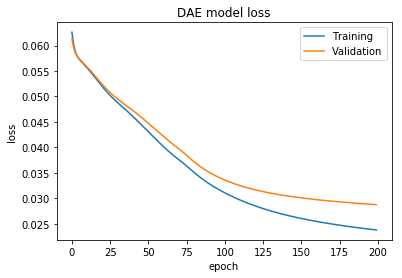

In [36]:
# DAE loss
plt.plot(ae_train['loss'])
plt.plot(ae_train['val_loss'])
plt.title('DAE model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [37]:
loss = pd.DataFrame(ae_train['loss'])
loss.describe()

,0
count,200.000000
mean,0.035137
std,0.010578
min,0.023782
25%,0.026075
50%,0.031141
75%,0.043134
max,0.062614


In [38]:
val_loss = pd.DataFrame(ae_train['val_loss'])
val_loss.describe()

,0
count,200.000000
mean,0.037774
std,0.009123
min,0.028743
25%,0.030109
50%,0.033641
75%,0.044790
max,0.061320


In [39]:
# create encoded data
encoded_data = encoder.predict(x_test)
#decoded_data = decoder.predict(encoded_data)

# transform to SOM input type
encoded_som = pd.DataFrame(encoded_data)
#decoded_som = pd.DataFrame(decoded_data)

In [40]:
encoded_data.mean()

0.9821817

In [41]:
encoded_som.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.000000,3.267661,-0.0,1.659051,-0.0,1.420627,0.877191,1.914744,1.734357,-0.0,-0.000000,1.879234
1,-0.000000,-0.000000,-0.0,3.078229,-0.0,0.648251,1.449205,3.801242,1.847487,-0.0,-0.000000,0.699434
2,-0.000000,-0.000000,-0.0,0.162422,-0.0,2.075658,1.709552,3.065782,2.461463,-0.0,-0.000000,1.426339
3,-0.000000,0.189977,-0.0,0.683508,-0.0,1.840549,2.455914,1.065598,0.563319,-0.0,0.451205,3.930484
4,0.014068,2.062477,-0.0,1.200067,-0.0,3.061901,2.570292,1.469035,0.562991,-0.0,-0.000000,0.127679


In [42]:
nonzero = list(map(lambda i: any(encoded_data[:,i] != 0), range(encoded_data.shape[1])))

encoded_som_nonzero = pd.DataFrame(encoded_data[:,nonzero])

encoded_som_nonzero.tail()

,0,1,2,3,4,5,6,7,8,9,10,11
405,-0.000000,3.252519,-0.000000,1.664136,-0.0,1.413815,0.866405,1.924757,1.727526,-0.0,-0.0,1.881566
406,-0.000000,0.114449,0.183713,1.324225,-0.0,0.033902,2.740770,2.486386,0.550868,-0.0,-0.0,3.165959
407,-0.000000,1.215400,-0.000000,1.805599,-0.0,2.416831,-0.000000,1.893669,1.963711,-0.0,-0.0,0.893533
408,0.001236,2.101959,-0.000000,1.211667,-0.0,3.043216,2.603950,1.454819,0.545969,-0.0,-0.0,0.126178
409,-0.000000,-0.000000,3.275495,0.182158,-0.0,2.205590,1.239869,2.057195,1.004302,-0.0,-0.0,1.597937


In [43]:
encoded_som_nonzero.to_csv(path_or_buf='output/dim064_DAE_encoded.csv',index= False)

# Convolutional Autoencoder

In [44]:
input_dim = x_train.shape[1]

# tranform the input format, add a dimension
x_train_con = x_train.as_matrix()
x_train_con = np.reshape(x_train_con, (-1, input_dim, 1))
x_text_con = x_test.as_matrix()
x_text_con = np.reshape(x_text_con, (-1, input_dim, 1))

input_layer = Input(shape=(input_dim,1))

x = Conv1D(32, 3, activation='relu', padding='same')(input_layer)
x = MaxPooling1D(4, padding='same')(x)
x = Conv1D(16, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(4, padding='same')(x)
x = Conv1D(4, 3, activation='relu', padding='same')(x)
encoded = MaxPooling1D(2, padding='same')(x)


x = Conv1D(4, 3, activation='relu', padding='same')(encoded)
x = UpSampling1D(2)(x)
x = Conv1D(16, 3, activation='relu', padding='same')(x)
x = UpSampling1D(4)(x)
x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = UpSampling1D(4)(x)
decoded = Conv1D(1, 1, activation='sigmoid')(x)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [45]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 64, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 32)            128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 16)            1552      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 4, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4, 4)              196       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 2, 4)              0         
__________

In [46]:
ae_train = autoencoder.fit(x_train_con, x_train_con,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(x_text_con, x_text_con),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')]).history

Train on 614 samples, validate on 410 samples


Epoch 1/200
614/614 [==============================] - 3s 4ms/step - loss: 0.0579 - val_loss: 0.0575

Epoch 2/200
614/614 [==============================] - 0s 237us/step - loss: 0.0569 - val_loss: 0.0565
Epoch 3/200
614/614 [==============================] - 0s 228us/step - loss: 0.0559 - val_loss: 0.0557
Epoch 4/200
614/614 [==============================] - 0s 227us/step - loss: 0.0554 - val_loss: 0.0557
Epoch 5/200
614/614 [==============================] - 0s 234us/step - loss: 0.0553 - val_loss: 0.0556
Epoch 6/200
614/614 [==============================] - 0s 233us/step - loss: 0.0552 - val_loss: 0.0555
Epoch 7/200
614/614 [==============================] - 0s 225us/step - loss: 0.0551 - val_loss: 0.0554
Epoch 8/200
614/614 [==============================] - 0s 235us/step - loss: 0.0550 - val_loss: 0.0554
Epoch 9/200
614/614 [==============================] - 0s 240us/step - loss: 0.0550 - val_loss: 0.0553
Epoch 10/200
614/614 [====

614/614 [==============================] - 0s 229us/step - loss: 0.0496 - val_loss: 0.0500
Epoch 74/200
614/614 [==============================] - 0s 211us/step - loss: 0.0495 - val_loss: 0.0499
Epoch 75/200
614/614 [==============================] - 0s 218us/step - loss: 0.0495 - val_loss: 0.0499
Epoch 76/200
614/614 [==============================] - 0s 225us/step - loss: 0.0494 - val_loss: 0.0499
Epoch 77/200
614/614 [==============================] - 0s 224us/step - loss: 0.0494 - val_loss: 0.0498
Epoch 78/200
614/614 [==============================] - 0s 225us/step - loss: 0.0493 - val_loss: 0.0498
Epoch 79/200
614/614 [==============================] - 0s 222us/step - loss: 0.0493 - val_loss: 0.0497
Epoch 80/200
614/614 [==============================] - 0s 232us/step - loss: 0.0493 - val_loss: 0.0497
Epoch 81/200
614/614 [==============================] - ETA: 0s - loss: 0.049 - 0s 245us/step - loss: 0.0492 - val_loss: 0.0496
Epoch 82/200
614/614 [==============================]

614/614 [==============================] - 0s 225us/step - loss: 0.0468 - val_loss: 0.0473
Epoch 152/200
614/614 [==============================] - 0s 225us/step - loss: 0.0467 - val_loss: 0.0473
Epoch 153/200
614/614 [==============================] - 0s 228us/step - loss: 0.0467 - val_loss: 0.0472
Epoch 154/200
614/614 [==============================] - 0s 228us/step - loss: 0.0467 - val_loss: 0.0472
Epoch 155/200
614/614 [==============================] - 0s 223us/step - loss: 0.0467 - val_loss: 0.0472
Epoch 156/200
614/614 [==============================] - 0s 226us/step - loss: 0.0467 - val_loss: 0.0472
Epoch 157/200
614/614 [==============================] - 0s 214us/step - loss: 0.0466 - val_loss: 0.0472
Epoch 158/200
614/614 [==============================] - 0s 212us/step - loss: 0.0466 - val_loss: 0.0472
Epoch 159/200
614/614 [==============================] - 0s 221us/step - loss: 0.0466 - val_loss: 0.0472
Epoch 160/200
614/614 [==============================] - 0s 222us/ste

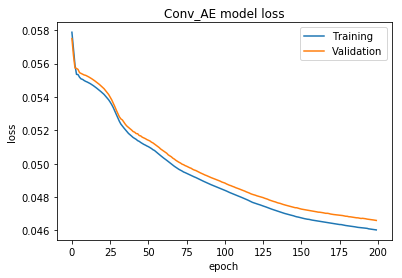

In [47]:
# Con_AE loss
plt.plot(ae_train['loss'])
plt.plot(ae_train['val_loss'])
plt.title('Conv_AE model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [48]:
loss = pd.DataFrame(ae_train['loss'])
loss.describe()

,0
count,200.000000
mean,0.049235
std,0.002876
min,0.046034
25%,0.046772
50%,0.048422
75%,0.051031
max,0.057876


In [49]:
val_loss = pd.DataFrame(ae_train['val_loss'])
val_loss.describe()

,0
count,200.000000
mean,0.049674
std,0.002774
min,0.046602
25%,0.047300
50%,0.048859
75%,0.051417
max,0.057497


In [50]:
encoded_data = encoder.predict(x_text_con)

In [51]:
encoded_data.shape

(410, 2, 4)

In [52]:
# create encoded data

encoded_data = encoded_data.reshape(-1, 2*4)

# transform to SOM input type
encoded_som = pd.DataFrame(encoded_data)
#decoded_som = pd.DataFrame(decoded_data)

In [53]:
encoded_data.mean()

0.66401666

In [54]:
encoded_som.head()

,0,1,2,3,4,5,6,7
0,-0.0,-0.0,3.360027,-0.0,-0.0,1.287915,1.160248,0.616803
1,-0.0,-0.0,1.466576,-0.0,-0.0,0.613625,2.414874,0.815550
2,-0.0,-0.0,3.205820,-0.0,-0.0,-0.000000,1.102885,0.905530
3,-0.0,-0.0,4.513686,-0.0,-0.0,0.301249,0.383365,0.758602
4,-0.0,-0.0,2.008009,-0.0,-0.0,0.648849,1.422501,0.844985


In [55]:
nonzero = list(map(lambda i: any(encoded_data[:,i] != 0), range(encoded_data.shape[1])))

encoded_som_nonzero = pd.DataFrame(encoded_data[:,nonzero])

encoded_som_nonzero.tail()

,0,1,2,3
405,3.350814,1.274927,1.140507,0.621154
406,3.934119,0.319135,1.320077,0.710896
407,2.167382,0.559387,1.212101,0.402231
408,2.033900,0.646862,1.427816,0.845780
409,2.123695,-0.000000,1.226861,0.407121


In [56]:
encoded_som_nonzero.to_csv(path_or_buf='output/dim064_ConAE_encoded.csv',index= False)